# How the CantusCorpus 1.0 dataset was prepared
This notebook documents how scraped Cantus Index data were modified (cleaned) before being exported as a dataset.  
This Jupyter notebook mainly documents how CantusCorpus 1.0 was constructed from scrapes of the Cantus Index database network from May 2025.  
In case anyone wants to scrape their (newer) data, e.g. via scripts from the `scraping` directory, this code can be used. 
It just needs the proper paths of the used files to be set and then some 'May 2025 CantusCorpus 1.0' specific steps to be changed or skipped.
  
We are providing two CSV files as a dataset:  
  - chants
  - sources
  
Main steps taken:
- Join all chant files by genre into one file
- Discard newlines from field values (esp. full text for strophic chants)
- Discard duplicates in chantlinks
- Genre standardisation based on the genre list in CI from which those records were from (issues only around Tp...)
- Discard data (from chants and sources), where for sources we cannot collect additional info
- Add a numerical century to sources
- Inspect duplicate sources: discard and unify duplicates
  
Finally, we are adding some basic statistics about the just-constructed dataset. That piece of code can be used again on different data via a path change.

In [39]:
import pandas as pd
import glob
import os

In [40]:
CHANTS_DIR_PATH = 'cantuscorpus_1.0/chants_by_genre' # Rename to fit your directory structure or fit your structure into this
SOURCES_CSV_PATH = 'cantuscorpus_1.0/scraped_sources.csv' # Rename to fit your directory structure or fit your structure into this

FINAL_CHANTS_CSV_PATH = 'cantuscorpus_1.0/chants.csv' # Rename to fit your directory structure or fit your structure into this
FINAL_SOURCES_CSV_PATH = 'cantuscorpus_1.0/sources.csv' # Rename to fit your directory structure or fit your structure into this

In [41]:
# Read static files
feast =pd.read_csv('cantuscorpus_1.0/static/feast.csv', dtype={'feast_code' : str})
genre = pd.read_csv('cantuscorpus_1.0/static/genre.csv')
office = pd.read_csv('cantuscorpus_1.0/static/office.csv')

In [42]:
sources = pd.read_csv(SOURCES_CSV_PATH)

# Chants
<br/>

In [43]:
# Concatenate chants data (chant records are in CSV files by genre)
concat_chants_files = glob.glob(CHANTS_DIR_PATH + '/*.csv')
chants_dfs_dict = {
    os.path.splitext(os.path.basename(file))[0] : pd.read_csv(file,  dtype=str) 
    for file in concat_chants_files
    }

# Clean full_texts
for file, df in chants_dfs_dict.items():
    df['full_text'] = df['full_text'].str.replace('\n', ' ').str.replace('\r', '')
    df['incipit'] = df['incipit'].str.replace('\n', ' ').str.replace('\r', '')
    df['volpiano'] = df['volpiano'].str.replace('\n', ' ').str.replace('\r', '')
chants = pd.concat(chants_dfs_dict, ignore_index=True)

# Store 'I am from Cantus Index genre lists XY' info
non_empty_genre = 0
for file, df in chants_dfs_dict.items():
    if len(df) > 0:
        non_empty_genre += 1
    df['genre_file'] = file
    df['full_text'] = df['full_text'].str.replace('\n', ' ').str.replace('\r', '')
    
print('number of genre files:', non_empty_genre)

chants_genre_file = pd.concat(chants_dfs_dict, ignore_index=True)

print('number of chant records - no processing:', len(chants))

number of genre files: 106
number of chant records - no processing: 1005793


In [44]:
# Analyze duplicates
print("number of not unique records in chantlinks in data:", 
                len(chants["chantlink"].value_counts()[lambda x: x > 1].index))
print("number of not unique rows in data:", 
                len(chants) - len(chants.drop_duplicates()))
print("number of not duplicit records with duplicit chantlink in data:", 
                len(chants.drop_duplicates()) - len(chants['chantlink'].drop_duplicates()))

number of not unique records in chantlinks in data: 117100
number of not unique rows in data: 117088
number of not duplicit records with duplicit chantlink in data: 12


Here comes May 2025 CantusCorpus 1.0 specific piece of work...

In [45]:
# Chants without duplicates
# turns out those 12 were records of AH49403 vs ah49403 so we gonna keep the lowercased version as being standard...

# Drop fully duplicated rows
df = chants.drop_duplicates()

# Find `chantlink` values that are still duplicated
dup_chantlinks = df['chantlink'].value_counts()[lambda x: x > 1].index

# Keep only rows with duplicated chantlink **and** cantus_id starting with lowercase letter
mask = (
    df['chantlink'].isin(dup_chantlinks) & 
    df['cantus_id'].str.match(r'^[a-z]')
)

# Keep rows that are either:
# - Not part of duplicated chantlinks
# - Or part of duplicated chantlinks AND their cantus_id starts with lowercase
chants = df[~df['chantlink'].isin(dup_chantlinks) | mask]
print("number of chants records without duplicates:", len(chants))

number of chants records without duplicates: 888693


### Genre
Searching for an overview of how various genre values are.  
If it's too messy, we can try to standardise it with the help of the "from this CI genre list" value we have for each chant record.

In [46]:
genres_in_data = set(chants['genre'])
print('Genres present in data and not in CI genre list:')
print(genres_in_data.difference(set(genre['genre_name'])))

Genres present in data and not in CI genre list:
{'Gr1V', '\xa0?', 'A14', 'Resp', 'R2', 'All+', 'V14', 'Off+', 'V6', 'All', 'Gr3', 'All1', 'V33', 'a', 'Tr4', 'Am4', 'V123', 'AllV', 'V124', 'Ant/Resp', 'a4', 'V9', 'LG', 'Gr2', 'a5', 'Ap', 'R11', 'Ant', 'V3', 'V2', 'Tr2', 'All6', 'V121', 'Hymn', 'Im', 'Am+', 'Am7', 'OffV', 'V10', '[a3]', 'R12', 'Am', 'R13', 'Ant1', 'R8', 'A7', 'M', 'Tr3', 'Gr+', 'r', 'R6', 'Comm', 'LDM', 'A9', 'R+', 'Varia/A', 'Dox', 'V31', 'V152', 'V122', 'Com', 'Am5', 'Intr', 'Varia', 'V151', 'All1V', 'Gr4V', 'Am6', 'R7', 'Seq', 'R1', 'HYMNV', 'V13', 'Gr5', 'V11', 'Ant3', 'Trop', 'R4', 'TrV', 'V3+', 'V126', 'a+', 'All3', 'All5', nan, 'All-1', 'An', 'IntrV', 'R15', 'Gr1', 'Am8', 'Be', 'R14', 'Off', 'Aproc', 'a1', 'All-V', 'Gr3V', 'A11', 'R10', 'Am2', 'V4', 'Comm+', 'a3', 'V5', 'V15', 'All-2', 'a3+', 'Tr', 'Ap+', 'CommV', 'Tr1', 'Gr-V', 'GRCV', 'Ant2', 'R3+', 'V32', 'Am3', 'Am9', 'RespV', 'a2+', 'V12', 'R5', 'R9', 'Gr4', 'An+', 'All2', 'V7', 'Ab+', 'A10', 'Vs', 'Ant4', '

Because we consider **genre** to be an important information, it makes sense to standardise it to CI values with the knowledge of in what genre list they are displayed in CI...  
This is a step where we are changing information from scraped JSON for our dataset.

In [47]:
# Just ensure we got genre value V and not [GV] value, that is already an empty list on the CI front-end
# Drop [GV] that are no longer displayed in CI (duplicates of V)
# This is done so we do not accidentally take [GV] somewhere
chants_genre_file = chants_genre_file[chants_genre_file['genre_file'] != '[GV]']

# Remove duplicates in chants_genre_file based on chantlink - so we are sure we have clear mapping
chants_genre_file = chants_genre_file.drop_duplicates(subset='chantlink', keep='first')

# For nonstandard values of genre we use value of genre_file instead
# Identify unacceptable genres
mask = ~chants['genre'].isin(set(genre['genre_name']))

# Create a mapping from chantlink to genre_file
genre_substitution_map = chants_genre_file.set_index('chantlink')['genre_file']

# Replace invalid genres using the mapping
chants.loc[mask, 'genre'] = chants.loc[mask, 'chantlink'].map(genre_substitution_map)

In [48]:
genres_in_data = set(chants['genre'])
print('Genres present in data and not in CI genre list after cleaning:')
print(genres_in_data.difference(set(genre['genre_name'])))

Genres present in data and not in CI genre list after cleaning:
{'[unknown]'}


In [49]:
# Lets substitute 'unknown' with '[?]' which is the original name of the list they are from
chants.loc[:, 'genre'] = chants['genre'].str.replace('[unknown]', '[?]', regex=False)

### Office
This is simply to be aware of how non-standardised this field is. There is not much to do about it besides passing the information.  

In [50]:
offices_in_data = set(chants['office'])
print('Offices present in data and not in CDB office list:')
numeric, alpha = [], []
for o in offices_in_data.difference(set(office['name'])):
    if str(o).isdigit():
        numeric.append(o)
    else:
        alpha.append(o)
print('\tnumeric:', numeric)
print('\tother:', alpha)

Offices present in data and not in CDB office list:
	numeric: ['964', '976', '980', '969', '970', '1002', '971', '979', '1003', '968', '1004', '975', '965', '966', '972', '974', '963', '978', '967', '977']
	other: ['Noc', 'Pec', nan, 'MH', 'S&O', 'Q&Q', 'P&S', 'AL', 'C2', 'DU&D', 'MASS', 'MN']


Numeric values are coming from the HunChant database.  
Hard to say if MI (from CDB) and MASS (from SEMM) mean really always the same thing or not...  
Overall, we are sticking to our policy of "being downstream", and so we would let the data be as they are.

### Melody overview

In [51]:
print('Number of melody_ids records:', len(chants['melody_id'].dropna()))
print('Number of melody_id values in data:', len(set(chants['melody_id'].dropna())))

Number of melody_ids records: 0
Number of melody_id values in data: 0


In [52]:
print('25 most frequent modes in data:')
chants['mode'].value_counts().head(25)

25 most frequent modes in data:


mode
*     121318
8      89894
1      79870
7      59778
4      44864
2      43350
3      30378
5      23932
r      22351
?      20456
6      18895
6T      4460
4T      3900
2T      3110
1S      3047
1T      2244
8S      1427
2S      1210
3S      1186
6S      1102
5S       986
7S       936
4S       805
G        738
8*       673
Name: count, dtype: int64

### Feasts
Since no clear standard exists on filed of feasts right now, we can provide only this simple numbers.

In [53]:
print('number of feasts recognized in CI list:', len(feast))
print('number of feast values in data:', len(set(chants['feast'])))

number of feasts recognized in CI list: 1794
number of feast values in data: 2401


# Sources
Just a quick look at scraped sources.  
Problems with http -> https for databases where redirect works corectly so the scraper did not notice (vs MMMO).   

In [54]:
# HTTP -> HTTPS
# all databases moved to https even in API except musmed 
# (http in source data is a mistake, allowed thanks to redirection, in sources scraping)
sources['srclink'] = sources['srclink'].apply(
    lambda x: x if not isinstance(x, str) else (
        x if x.startswith('http://musmed') else x.replace('http://', 'https://')
    )
)
# Clean spaces in fields
sources['siglum'] = sources['siglum'].str.strip()
sources['title'] = sources['title'].str.strip()
sources['provenance'] = sources['provenance'].str.strip()

In [55]:
# For how many sources mentioned in data we do not have source information scraped
sources_in_data = set(chants['srclink'])
scraped_sources = set(sources['srclink'])
print('Number of sources being scraped and not present in data:', 
      len(scraped_sources.difference(sources_in_data)))
print()
print('Number of sources being in data and not in scraped sources info:', 
      len(sources_in_data.difference(scraped_sources)) )

Number of sources being scraped and not present in data: 0

Number of sources being in data and not in scraped sources info: 30


##### Very "data version" specific piece of code follows:

In [56]:
# Inspect those 30 troublemakers 
hispanica_once = []
fontes_once = []
others = []
for trouble_source_URL in sources_in_data.difference(scraped_sources):
    if 'hispanica' in trouble_source_URL:
        hispanica_once.append(trouble_source_URL)
    elif 'cantusbohemiae' in trouble_source_URL:
        fontes_once.append(trouble_source_URL)
    else:
        others.append(trouble_source_URL)

print('hispanica:', len(hispanica_once))
for url in hispanica_once:
    print(url)
print('FCB:', len(fontes_once))
for url in fontes_once:
    print(url)
print('others:', len(others))
for url in others:
    print(url)

hispanica: 12
https://musicahispanica.eu/source/25465
https://musicahispanica.eu/source/25466
https://musicahispanica.eu/source/25461
https://musicahispanica.eu/source/25468
https://musicahispanica.eu/source/25462
https://musicahispanica.eu/source/25467
https://musicahispanica.eu/source/25460
https://musicahispanica.eu/source/25319
https://musicahispanica.eu/source/25464
https://musicahispanica.eu/source/25463
https://musicahispanica.eu/source/25469
https://musicahispanica.eu/source/25470
FCB: 18
https://cantusbohemiae.cz/source/22705
https://cantusbohemiae.cz/source/2147
https://cantusbohemiae.cz/source/22098
https://cantusbohemiae.cz/source/4443
https://cantusbohemiae.cz/source/11619
https://cantusbohemiae.cz/source/9192
https://cantusbohemiae.cz/source/22179
https://cantusbohemiae.cz/source/9188
https://cantusbohemiae.cz/source/22153
https://cantusbohemiae.cz/source/22046
https://cantusbohemiae.cz/source/10804
https://cantusbohemiae.cz/source/9185
https://cantusbohemiae.cz/source/21

Those hispanica sources are all fragments of one manuscript and all are missing Shelfmark (-> siglum), but we can get that value directly from their chant records, where siglum is required field - we have to add these 12 sources manually before dataset realese. 
   
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 4"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 7"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 12"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 10.2"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 6"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 5"  
"E-BAR, Archivo Diocesano de Barbastro, Carp. nº 66: Frag. 2"  
"E-BAR, Archivo Diocesano de Barbastro, Carp. nº 66: Frag. 3"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 11  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 9"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 10.1"  
"E-BAR, Archivo Diocesano de Barbastro, Carp, nº 66: Frag. 8"

Those FCB source pages are returning 'Acces denied'...  
Since we did not manage to get info about reason of this hidding, we decided to discard their chant records in case these sources were hidden due to some quality problems etc.

In [57]:
print('number of chant records before discarding problematic FCB sources:', len(chants))
for srclink in fontes_once:
    # Discard "FCB hidden sources" records in chants
    chants = chants[chants['srclink'] != srclink]
print('number of chant records after discarding problematic FCB sources:', len(chants))

number of chant records before discarding problematic FCB sources: 888693
number of chant records after discarding problematic FCB sources: 888110


### Duplicity in sources...?
We want to have a look at how unique value siglum is.

In [58]:
# Look for duplicity in sigla
print(sources['siglum'].value_counts()[lambda x : x > 1])

siglum
PL-PŁsem MsEPl 12                                 2
CZ-OLu M III 6                                    2
SK-KRE 1625                                       2
CZ-Pn XII A 24                                    2
A-KN CCl 1018                                     2
CZ-Pn XV A 10                                     2
CZ-Pu VI G 3a                                     2
P-LA Caixa 2, Fragmento 017                       2
CZ-Pu XIV G 46                                    2
SK-KRE Tom. 1, Fons 32, Fasc. 9, Nro. 83, 1583    2
SK-KRE Tom. 2, Fons 41, Fasc. 1, Nro. 3, 1601     2
Name: count, dtype: int64


In [59]:
# Lets inspect them 
for siglum in sources['siglum'].value_counts()[lambda x : x > 1].index:
    srclinks = list(sources[sources['siglum'] == siglum]['srclink'])
    srclink1 = srclinks[0]
    print('number of chants in', srclink1, siglum, ':', len(chants[chants['srclink'] == srclink1]))
    srclink2 = srclinks[1]
    print('number of chants in', srclink2, siglum, ':', len(chants[chants['srclink'] == srclink2]))
    print('---------------------')

number of chants in https://cantusplanus.pl/source/14457 PL-PŁsem MsEPl 12 : 2019
number of chants in https://cantusplanus.pl/source/14458 PL-PŁsem MsEPl 12 : 1825
---------------------
number of chants in https://cantusbohemiae.cz/source/11616 CZ-OLu M III 6 : 467
number of chants in https://hymnologica.cz/source/6983 CZ-OLu M III 6 : 156
---------------------
number of chants in https://cantus.sk/source/32083 SK-KRE 1625 : 4
number of chants in https://cantus.sk/source/32224 SK-KRE 1625 : 3
---------------------
number of chants in https://cantusbohemiae.cz/source/33177 CZ-Pn XII A 24 : 865
number of chants in https://hymnologica.cz/source/10619 CZ-Pn XII A 24 : 16
---------------------
number of chants in https://cantusdatabase.org/source/123616 A-KN CCl 1018 : 2776
number of chants in https://austriamanus.org/source/3620 A-KN CCl 1018 : 21
---------------------
number of chants in https://cantusbohemiae.cz/source/28509 CZ-Pn XV A 10 : 2884
number of chants in https://hymnologica.cz

**A-KN CCl 1018** - TWO different books having the same sigla on URL pages - in CDB and A4M - probably A4M one is a piece of parchment inserted inside book referd to by CDB  
**SK-KRE Tom. 2, Fons 41, Fasc. 1, Nro. 3, 1601** - two parts of the same book with separate URL entries  
**SK-KRE Tom. 1, Fons 32, Fasc. 9, Nro. 83, 1583** - two parts of the same book with separate URL entries  
**PL-PŁsem MsEPl 12** - two parts of the same book with separate URL entries  

##### Very "data version" specific piece of code follows:

In [60]:
# And these needs to be inspect on overlaping chant records:
# P-LA Caixa 2, Fragmento 017 - https://musicahispanica.eu/source/62316 and https://pemdatabase.eu/source/46528
caixa2PEM = chants[chants['srclink'] == "https://pemdatabase.eu/source/46528"]
caixa2SEMM = chants[chants['srclink'] == "https://musicahispanica.eu/source/62316"]
print('P-LA Caixa 2, Fragmento 017')
print('number of chants in manuscripts:', len(caixa2PEM), len(caixa2SEMM))
print('size of interesection:', len(set(caixa2SEMM['cantus_id']).intersection(set(caixa2PEM['cantus_id']))))
print()
# Both records complete -> we have to discard one of them - in sources as well as in chants...

# CZ-Pu VI G 3a - https://hymnologica.cz/source/5364 and https://cantusbohemiae.cz/source/9147
viFCB = chants[chants['srclink'] == "https://cantusbohemiae.cz/source/9147"]
viHYM = chants[chants['srclink'] == "https://hymnologica.cz/source/5364"]
print('VI G 3a, folios in HYM & not in FCB:', set(viHYM[['folio', 'cantus_id']]).difference(set(viFCB[['folio', 'cantus_id']])))
print('VI G 3a, folios in HYM & in FCB:', set(viHYM['folio']).intersection(set(viFCB['folio'])))
vi_dupl_folios_cids = set(zip(viHYM['folio'], viHYM['cantus_id'])).intersection(set(zip(viFCB['folio'], viFCB['cantus_id'])))
print()
# CZ-Pn XII A 24 https://hymnologica.cz/source/10619  and https://cantusbohemiae.cz/source/33177
xiiFCB = chants[chants['srclink'] == "https://cantusbohemiae.cz/source/33177"]
xiiHYM = chants[chants['srclink'] == "https://hymnologica.cz/source/10619"]
print('XII A 24, folios in HYM & not in FCB:', set(xiiHYM['folio']).difference(set(xiiFCB['folio'])))
print('XII A 24, folios in HYM & in FCB:', set(xiiHYM['folio']).intersection(set(xiiFCB['folio'])))
xii_dupl_folios_cids = set(zip(xiiHYM['folio'], xiiHYM['cantus_id'])).intersection(set(zip(xiiFCB['folio'], xiiFCB['cantus_id'])))
print()
# CZ-Pn XV A 10 - https://hymnologica.cz/source/47  and https://cantusbohemiae.cz/source/28509
xvFCB = chants[chants['srclink'] == "https://cantusbohemiae.cz/source/28509"]
xvHYM = chants[chants['srclink'] == "https://hymnologica.cz/source/47"]
print('XV A 10, folios in HYM & not in FCB:', set(xvHYM['folio']).difference(set(xvFCB['folio'])))
print('XV A 10, folios in HYM & in FCB:', set(xvHYM['folio']).intersection(set(xvFCB['folio'])))
xv_dupl_folios_cids = set(zip(xvHYM['folio'], xvHYM['cantus_id'])).intersection(set(zip(xvFCB['folio'], xvFCB['cantus_id'])))
print()
# CZ-Pu XIV G 46 - https://hymnologica.cz/source/5366 and https://cantusbohemiae.cz/source/9194
xivFCB = chants[chants['srclink'] == "https://cantusbohemiae.cz/source/9194"]
xivHYM = chants[chants['srclink'] == "https://hymnologica.cz/source/5366"]
print('XIV G 64, folios in HYM & not in FCB:', set(xivHYM['folio']).difference(set(xivFCB['folio'])))
print('XIV G 64, folios in HYM & in FCB:', set(xivHYM['folio']).intersection(set(xivFCB['folio'])))
xiv_dupl_folios_cids = set(zip(xivHYM['folio'], xivHYM['cantus_id'])).intersection(set(zip(xivFCB['folio'], xivFCB['cantus_id'])))
print()
# CZ-OLu M III 6 - https://hymnologica.cz/source/6983 and https://cantusbohemiae.cz/source/11616
iiiFCB = chants[chants['srclink'] == "https://cantusbohemiae.cz/source/11616"]
iiiHYM = chants[chants['srclink'] == "https://hymnologica.cz/source/6983"]
iii_dupl_folios_cids = set(zip(iiiHYM['folio'], iiiHYM['cantus_id'])).intersection(set(zip(iiiFCB['folio'], iiiFCB['cantus_id'])))
print('M III 6: FCB:', len(iiiFCB), 'HYM:', len(iiiHYM))
print('number of folios in HYM that are not in FCB:', len(set(iiiHYM['folio']).difference(set(iiiFCB['folio']))))
print('Genres in HYM chants:', iiiHYM['genre'].value_counts())

P-LA Caixa 2, Fragmento 017
number of chants in manuscripts: 8 8
size of interesection: 8

VI G 3a, folios in HYM & not in FCB: set()
VI G 3a, folios in HYM & in FCB: {'114v', '099r', '105r', '114r', '109r', '102r', '097r', '110r', '056r', '108r', '106r', '104r', '101v', '110v', '113v', '109v', '097v', '112r', '099v', '108v', '101r', '106v', '107v', '104v', '062v', '102v', '105v', '103r', '096v', '112v', '103v', '111r'}

XII A 24, folios in HYM & not in FCB: set()
XII A 24, folios in HYM & in FCB: {'029r', '028v', '002r', '028r', '001v', '029v'}

XV A 10, folios in HYM & not in FCB: set()
XV A 10, folios in HYM & in FCB: {'007r', '007v', '040v'}

XIV G 64, folios in HYM & not in FCB: {'074v', '080r'}
XIV G 64, folios in HYM & in FCB: {'116v'}

M III 6: FCB: 467 HYM: 156
number of folios in HYM that are not in FCB: 112
Genres in HYM chants: genre
Sq    156
Name: count, dtype: int64


#### Troublemakers in duplicite sigla solving
P-LA Caixa 2, Fragmento 017  
-> lets discard PEM record since SEMM has full_texts

In [61]:
# Discard duplicate PEM source - in sources as well as in chants
chants = chants[chants['srclink'] != "https://pemdatabase.eu/source/46528"]
sources = sources[sources['srclink'] != "https://pemdatabase.eu/source/46528"]

FCB 'vs' HYM  
- lets keep non-duplicate chants records from both - just change srclink from HYM one to FCB one (but keep HYM chantlink and db)  
- discard HYM records in sources  
- here we are changing srclinks in data from scraped JSONs

In [62]:
hymnologica_links = [
    "https://hymnologica.cz/source/5364",
    "https://hymnologica.cz/source/10619",
    "https://hymnologica.cz/source/47",
    "https://hymnologica.cz/source/5366",
    "https://hymnologica.cz/source/6983"
]
# Discard HYM chant records where FCB equivalent exists
# we would try to detect this based on folio and cantus_id
duplicate_pairs = list(xii_dupl_folios_cids) + list(xiv_dupl_folios_cids) + list(xv_dupl_folios_cids) + list(iii_dupl_folios_cids) + list(vi_dupl_folios_cids)
mask = chants.apply(
    lambda row: ((row['folio'], row['cantus_id']) in duplicate_pairs) and (row['srclink'] in hymnologica_links),
    axis=1
)

print('number of chant records before HYM duplicites discarding:', len(chants))
# Filter out the rows where mask is True
empt_chants = chants[~mask].reset_index(drop=True)
print('number of chant records after HYM duplicites discarding:', len(empt_chants))
chants = empt_chants

number of chant records before HYM duplicites discarding: 888102
number of chant records after HYM duplicites discarding: 888010


In [63]:
# Change HYM srclinks to FCB once in chants
chants.loc[chants['srclink'] == "https://hymnologica.cz/source/5364", 'srclink'] = "https://cantusbohemiae.cz/source/9147"
chants.loc[chants['srclink'] == "https://hymnologica.cz/source/10619", 'srclink'] = "https://cantusbohemiae.cz/source/33177"
chants.loc[chants['srclink'] == "https://hymnologica.cz/source/47", 'srclink'] = "https://cantusbohemiae.cz/source/28509"
chants.loc[chants['srclink'] == "https://hymnologica.cz/source/5366", 'srclink'] = "https://cantusbohemiae.cz/source/9194"
chants.loc[chants['srclink'] == "https://hymnologica.cz/source/6983", 'srclink'] = "https://cantusbohemiae.cz/source/11616"

# Discard HYM sources in sources
sources = sources[~sources['srclink'].isin(hymnologica_links)]

### Numerical century
For better computational processing, we decided to add a new column to source records - numerical century = integer representing century of origin based on what is filled in the century field.  
(Again, general code follows.)

In [64]:
import re

In [65]:
# Numerical century
def get_numerical_century(century : str) -> int:
    """
    Extracts the numerical century from a string representation of a century.
    """
    try:
        # Go for years first
        four_digits_pattern = r'(?<!\d)\d{4}(?!\d)'
        four_digits_match = re.findall(four_digits_pattern, century)
        if four_digits_match is not None:
            if len(four_digits_match) == 1:
                return int(four_digits_match[0][0:2])+1
            elif len(four_digits_match) > 1: 
                # take first founded number anyway
                return int(four_digits_match[0][0:2])+1
        # Ideally catches cases like "12th century" or "08th century"
        two_digits_pattern = r'(?<!\d)\d{2}(?!\d)'
        two_digits_match = re.findall(two_digits_pattern, century)
        if len(two_digits_match) == 1:
            return int(two_digits_match[0])
        elif len(two_digits_match) > 1: 
            # take first anyway
            return int(two_digits_match[0])
        # For the case of single digit centuries like "9th century"
        one_digit_pattern = r'(?<!\d)\d{1}(?!\d)'
        one_digit_match = re.findall(one_digit_pattern, century)
        if len(one_digit_match) == 1:
            return int(one_digit_match[0])
    
        # If we reach here, we did not find a century - REPORT
        print('PROBLEM:', century)
    except: # probably nan coming
        return ''

In [66]:
# Apply numerical century creation on data about sources
sources['num_century'] = sources['century'].apply(get_numerical_century)

### Cursus

In [67]:
print('number of sources:', len(sources))
print()
print('distribution of cursus values in sources:')
print(sources['cursus'].value_counts())

number of sources: 2266

distribution of cursus values in sources:
cursus
Secular      196
Monastic      86
cathedral     49
unknown       35
Romanum       14
Name: count, dtype: int64


### Provenance


In [68]:
print('number of provenance values in data:', len(set(sources['provenance'])))
print('\n15 most common provenance values in data:')
print(sources['provenance'].value_counts().head(15))

number of provenance values in data: 642

15 most common provenance values in data:
provenance
Slovakia                                       110
Bohemia                                         63
Klosterneuburg                                  63
Hungary                                         57
Austria/Germany                                 44
Austria                                         44
Central Europe                                  40
Germany                                         30
medieval Hungary                                28
Italy                                           24
Augsburg                                        22
Hungary (Spiš region)                           20
St Gallen                                       20
Moravia/ Slovakia: Nové Mesto nad Váhom (?)     16
Bratislava                                      16
Name: count, dtype: int64


## Throw away not used fields
We have quite a lot fields in our data - mostly a legacy of CantusCorpus v0.2 (Bas Cornelissen, 2020), that was based only on CDB - that are empty, which we would like to get rid of as part of this data cleaning.

In [69]:
discard_columns_chants = ['corpus_id', 'finalis', 'differentia', 'marginalia', 
                          'cao_concordances', 'notes', 'dataset_name', 'dataset_idx',
                          'full_text_manuscript']

In [70]:
discard_columns_sources = ['image_link', 'n_cantus_chants', 'n_cantus_melodies', 'provenance_detail',
                           'segment','summary', 'indexing_notes', 'liturgical_occasions', 'indexing_date',
                           'description', 'rism', 'date']

In [71]:
# Discard selected empty columns in chants
for col in discard_columns_chants:
    if col in chants.columns:
        chants.drop(columns=[col], inplace=True)

In [72]:
# Discard selected empty columns in sources
for col in discard_columns_sources:
    if col in sources.columns:
        sources.drop(columns=[col], inplace=True)

In [73]:
# Rename image_link to image to link with pycantus and CI API names
chants.rename(columns={'image_link': 'image'}, inplace=True)

In [74]:
# Rename 'volpiano' to 'melody' to link with pycantus and CI API names
chants.rename(columns={'volpiano': 'melody'}, inplace=True)

In [77]:
chants.drop(columns=['id'], inplace=True)

In [78]:
print(chants.columns)

Index(['chantlink', 'incipit', 'cantus_id', 'mode', 'siglum', 'position',
       'folio', 'sequence', 'feast', 'feast_code', 'genre', 'office',
       'srclink', 'melody_id', 'full_text', 'melody', 'db', 'image'],
      dtype='object')


## Store what we have done
(Do not forget then to add manually 12 Hispanica fragments after storing sources => or simply anything you decided to do manually.)

In [79]:
# Save chants after all changes
chants.to_csv(FINAL_CHANTS_CSV_PATH, index=False)
# Save sources after all changes
sources.to_csv(FINAL_SOURCES_CSV_PATH, index=False)

# Statistics
Here we computed basic statistics about our dataset.
- number of chant records
- out of them, how many have:
    - some melody in volpiano
    - melody in volpiano - more than 20 notes
______
- number of source manuscripts of these records
- out of them, how many have:
    - provenance
    - century
    - cursus

------
- plot distributions of some values over chants or sources

In [ ]:
chants = pd.read_csv(FINAL_CHANTS_CSV_PATH[:-4]+'_processed.csv', dtype=str)
sources = pd.read_csv(SOURCES_CSV_PATH[:-4]+'_processed.csv', dtype=str)

### Chants

In [66]:
from utils import clean_volpiano
print('number of chants records after all processing:', len(chants))
print('out of them number of:')
print('\tchant records with some melody in volpiano:', len(chants['volpiano'].dropna()))
print('\tchant records with melody of more than 20 notes:', chants['volpiano'].dropna().apply(lambda x: len(clean_volpiano(x)) >= 20).sum())

number of chants records after all processing: 888010
out of them number of:
	chant records with some melody in volpiano: 60588
	chant records with melody of more than 20 notes: 44625


### Sources

In [67]:
print('number of sources records after all processing:', len(sources))
print('out of them number of:')
print('\tsources with provenance value:', len(sources[sources['provenance'].notna()]))
print('\tsources with century value:', len(sources[sources['century'].notna()]))
print('\tsources with cursus value:', len(sources[sources['cursus'].notna()]) - len(sources[sources['cursus'] == 'unknown']))

number of sources records after all processing: 2278
out of them number of:
	sources with provenance value: 1606
	sources with century value: 2240
	sources with cursus value: 345


### Distribution plots

<Axes: xlabel='Genre', ylabel='Number of chants'>

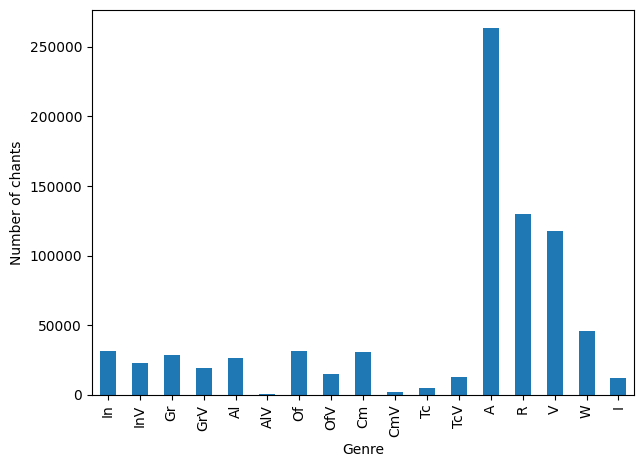

In [68]:
# Plot distribution of chants in selected main genres
GENRES_MASS_PROPERS = ['In', 'InV', 'Gr', 'GrV', 'Al', 'AlV', 'Of', 'OfV', 'Cm', 'CmV', 'Tc', 'TcV']
GENRES_OFFICE = ['A', 'R', 'V', 'W', 'I']
MAIN_GENRES = GENRES_MASS_PROPERS + GENRES_OFFICE
chants['genre'].value_counts().loc[MAIN_GENRES].plot(kind='bar', xlabel='Genre', ylabel='Number of chants', figsize=(7, 5))

<Axes: xlabel='Office', ylabel='Number of chants'>

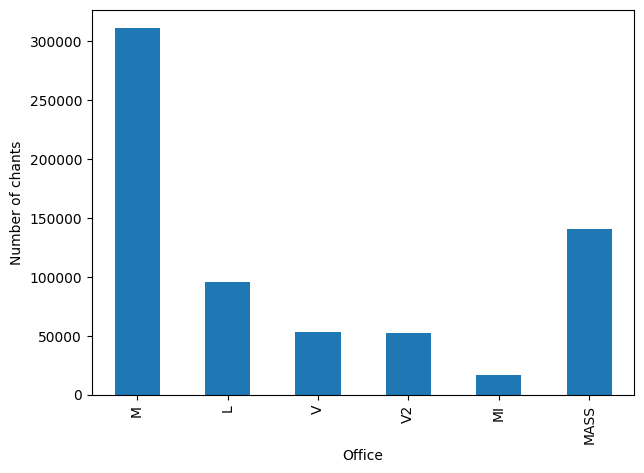

In [69]:
# Plot istrbution of chants in selected main offices
MAIN_OFFICES = ['M', 'L', 'V', 'V2', 'MI', 'MASS']
chants['office'].value_counts().loc[MAIN_OFFICES].plot(kind='bar', xlabel='Office', ylabel='Number of chants', figsize=(7, 5))

<Axes: xlabel='Mode', ylabel='Number of chants'>

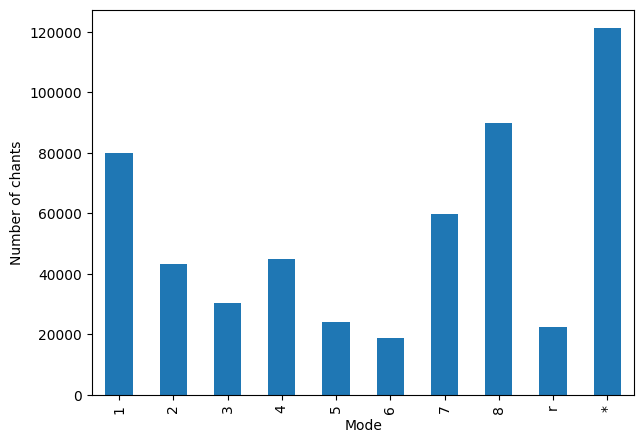

In [70]:
# Plot distribution of selected main modes
MAIN_MODES = ['1', '2', '3', '4', '5', '6', '7', '8',
              'r', '*']
chants['mode'].value_counts().loc[MAIN_MODES].plot(kind='bar', xlabel='Mode', ylabel='Number of chants', figsize=(7, 5))

<Axes: xlabel='Century', ylabel='Number of sources'>

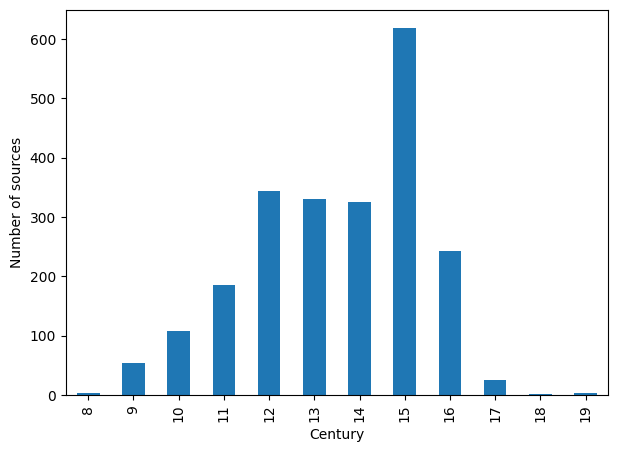

In [71]:
# Distribution of sources by century - use num_century column retyped to int
sources['num_century'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', xlabel='Century', ylabel='Number of sources', figsize=(7, 5))